# Temperature_v2

This is an assignment for my thinkful data science course - "Temperature_v2"
Raj Prasad
May 2019


[html version](https://daddyprasad5.github.io/Temperature_v2.html) - with all the code hidden away for a quick read

[jupyter notebook version](https://github.com/daddyprasad5/thinkful/blob/master/Temperature_v2.ipynb) - with all the code exposed in an interactive notebook

## Temperatures dataset

I'm demonstrating a linear regression modeling on a weather dataset originally from Kaggle. This dataset consists of 12 varibles describing hourly weather observations Szeged, Hungary area, between 2006 and 2016. You can find the descriptions of the variables [here](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data).

The target variable is the difference between the apparenttemperature and the temperature. As explanatory variables, we'll first use humidity and windspeed.  Then we'll add the interaction of humidity and windspeed. 

The focus of this exercise is on interpretation of coefficients. 


In [31]:
#imports & connection
import numpy as np
import pandas as pd
from sklearn import linear_model
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
import statsmodels.api as sm
import seaborn as sns
from scipy.stats import zscore
from scipy.stats.mstats import winsorize
import scipy.stats as stats
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms

import warnings
warnings.filterwarnings('ignore')

In [32]:
#db connection
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'weatherinszeged'

In [33]:
#data load
engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))
weather_df = pd.read_sql_query('select * from weatherinszeged',con=engine)

# no need for an open connection, as we're only doing a single query
engine.dispose()



In [34]:
weather_df.head()

,date,summary,preciptype,temperature,apparenttemperature,humidity,windspeed,windbearing,visibility,loudcover,pressure,dailysummary
0,2006-03-31 22:00:00+00:00,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,Partly cloudy throughout the day.
1,2006-03-31 23:00:00+00:00,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,1015.63,Partly cloudy throughout the day.
2,2006-04-01 00:00:00+00:00,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94,Partly cloudy throughout the day.
3,2006-04-01 01:00:00+00:00,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,0.0,1016.41,Partly cloudy throughout the day.
4,2006-04-01 02:00:00+00:00,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,0.0,1016.51,Partly cloudy throughout the day.


In [35]:
weather_df.describe()

,temperature,apparenttemperature,humidity,windspeed,windbearing,visibility,loudcover,pressure
count,96453.000000,96453.000000,96453.000000,96453.000000,96453.000000,96453.000000,96453.0,96453.000000
mean,11.932678,10.855029,0.734899,10.810640,187.509232,10.347325,0.0,1003.235956
std,9.551546,10.696847,0.195473,6.913571,107.383428,4.192123,0.0,116.969906
min,-21.822222,-27.716667,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
25%,4.688889,2.311111,0.600000,5.828200,116.000000,8.339800,0.0,1011.900000
50%,12.000000,12.000000,0.780000,9.965900,180.000000,10.046400,0.0,1016.450000
75%,18.838889,18.838889,0.890000,14.135800,290.000000,14.812000,0.0,1021.090000
max,39.905556,39.344444,1.000000,63.852600,359.000000,16.100000,0.0,1046.380000


In [36]:
weather_df.describe(include="O")

,summary,preciptype,dailysummary
count,96453,96453,96453
unique,27,3,214
top,Partly Cloudy,rain,Mostly cloudy throughout the day.
freq,31733,85224,20085


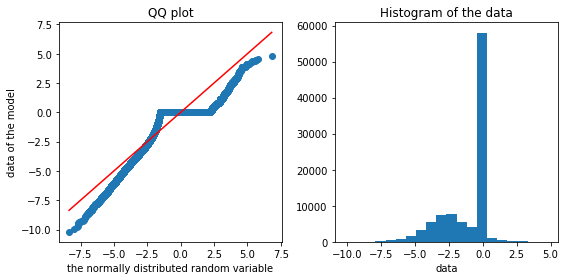

Jarque-Bera test statistics is 29042.869621302503 and p value is 0.0
Normality test statistics is 17635.587678501455 and p value is 0.0


In [37]:
# target variable distribution

apparent_discrepancy = weather_df.apparenttemperature - weather_df.temperature

def check_normality(data): 
    rand_nums = np.random.normal(np.mean(data), np.std(data), len(data))

    plt.figure(figsize=(8,4))
    
    x = np.sort(rand_nums)
    y = data.sort_values()

    plt.subplot(1,2,1)
    plt.scatter(np.sort(rand_nums), data.sort_values())
    plt.xlabel("the normally distributed random variable")
    plt.ylabel("data of the model")
    plt.plot(x, x, c="red")
    plt.title("QQ plot")

    plt.subplot(1,2,2)
    plt.hist(data, bins = 20)
    plt.xlabel("data")
    plt.title("Histogram of the data")

    plt.tight_layout()
    plt.show()

    from scipy.stats import jarque_bera
    from scipy.stats import normaltest

    jb_stats = jarque_bera(data)
    norm_stats = normaltest(data)

    print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
    print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))
    
check_normality(apparent_discrepancy)

We observe that temperature distribution is not normal.

In [8]:
#there are no missing values.  nice.

def find_nulls(df): 
    total_missing = df.isnull().sum().sort_values(ascending=False)
    percent_missing = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
    return pd.concat([total_missing, percent_missing], axis=1, keys=['Total', 'Percent'])
    

def remove_null_cols(df):
    n = len(df)
    cols = df.columns
    null_cols = [(len(df[df[col].isnull()]) == 0) for col in df]
    return df.iloc[:, null_cols]

find_nulls(weather_df)

,Total,Percent
dailysummary,0,0.0
pressure,0,0.0
loudcover,0,0.0
visibility,0,0.0
windbearing,0,0.0
windspeed,0,0.0
humidity,0,0.0
apparenttemperature,0,0.0
temperature,0,0.0
preciptype,0,0.0


In [9]:
weather_df.columns

Index(['date', 'summary', 'preciptype', 'temperature', 'apparenttemperature',
       'humidity', 'windspeed', 'windbearing', 'visibility', 'loudcover',
       'pressure', 'dailysummary'],
      dtype='object')

In [38]:
#define the feature set

feature_cols = ["humidity", "windspeed"]

features = weather_df[feature_cols]

features.head()

,humidity,windspeed
0,0.89,14.1197
1,0.86,14.2646
2,0.89,3.9284
3,0.83,14.1036
4,0.83,11.0446


In [39]:
# create the model...
# Y is the target variable
Y = apparent_discrepancy
# X is the feature set which includes
# is_male and is_smoker variables
X = features

# We need to manually add a constant
# in statsmodels' sm
X = sm.add_constant(X)

lrm = sm.OLS(Y, X)

results = sm.OLS(Y, X).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.288
Model:                            OLS   Adj. R-squared:                  0.288
Method:                 Least Squares   F-statistic:                 1.949e+04
Date:                Wed, 29 May 2019   Prob (F-statistic):               0.00
Time:                        04:17:45   Log-Likelihood:            -1.7046e+05
No. Observations:               96453   AIC:                         3.409e+05
Df Residuals:                   96450   BIC:                         3.409e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.4381      0.021    115.948      0.000       2.397       2.479
humidity      -3.0292      0.024   -126.479      0.000      -3.076      -2.982
windspeed     -0.1193      0.001   -176.164      0.000      -0.121      -0.118
==============================================================================
Omnibus:                     3935.747   Durbin-Watson:                   0.267
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4613.311
Skew:                          -0.478   Prob(JB):                         0.00
Kurtosis:                       3.484   Cond. No.                         88.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Interpreting the coefficients: 

**Are the estimated coefficients statistically significant?**
The p value for both is 0.000 - very low indeed and indicates we can reject the null hypothessis that the coefficient for the underlying population is 0.  However, note that the errors are not normally distributed (see below).  Normally distributed errors are required for us to estimate the significance of coefficients. 

**Are the signs of the estimated coefficients in line with your previous expectations?**
Both are negative.  As humidity rises apparent temperature less actual temperature, i.e. they get closer together.  Likewise for wind speed.  That's suprising.  I would expect the opposite - that humidity and windspeed would cause confuse our perception of temperature.   

**Interpret the estimated coefficients. What are the relations between the target and the explanatory variables?**
If I put aside the concern about non-normal errors, and assume that the coefficients are significant, then on average I would expect the discrepancy between apparent and actual temperature to reduce by 3 degrees celsius for each 1 unit change in humidity and by 0.1 degrees for each one unit change in windspeed. 

In [40]:
#1. linearity of models in their coefficients - the model chosen de facto satisfies this condition

In [41]:
#2. the error term should be zero on average - and it is very close.  No concerns here. 
#predictions = results.fittedvalues
predictions = results.predict(X)
errors = Y - predictions
print("Mean of the errors in the medical costs model is: {}".format(np.mean(errors)))

Mean of the errors in the medical costs model is: -9.168920724461148e-15


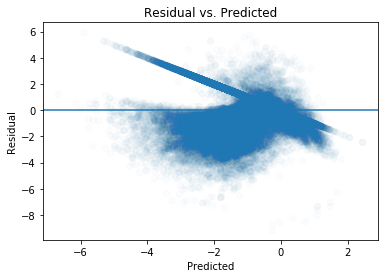

Bartlett test statistic value is 19150.8 and p value is 0
Levene test statistic value is 14884.8 and p value is 0


In [42]:
#3. homoscedasticity: the errors are consistently distributed  
plt.scatter(predictions, errors, alpha = .02)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

from scipy.stats import bartlett
from scipy.stats import levene

bart_stats = bartlett(predictions, errors)
lev_stats = levene(predictions, errors)

print("Bartlett test statistic value is {0:3g} and p value is {1:.3g}".format(bart_stats[0], bart_stats[1]))
print("Levene test statistic value is {0:3g} and p value is {1:.3g}".format(lev_stats[0], lev_stats[1]))

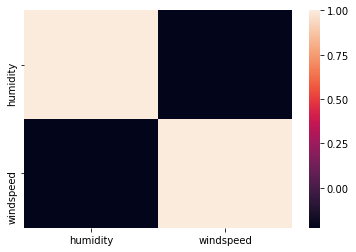

In [43]:
#4. low multicollinearity  
sns.heatmap(features.corr())
plt.show()

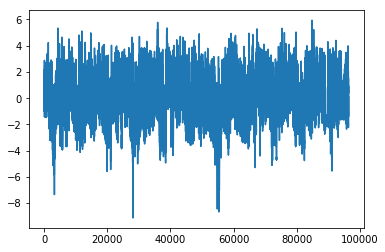

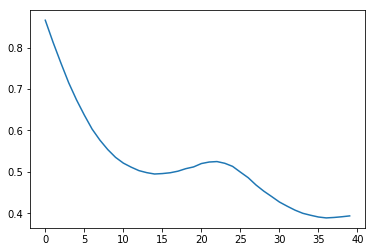

In [44]:
#5. ERROR TERMS ARE HIGHLY CORRELATED WITH EACH OTHER 
plt.plot(errors)
plt.show()

from statsmodels.tsa.stattools import acf

acf_data = acf(errors)

plt.plot(acf_data[1:])
plt.show()

In [45]:
#6. features shouldn't be correlated with the errors - and they aren't

f_err_corrs = [abs(features[feature].corr(errors)) for feature in features.columns]

high_corrs = [(x > 0.1) for x in f_err_corrs]

high_errs_df = pd.DataFrame([features.columns, f_err_corrs]).transpose()[high_corrs]
high_errs_df.columns = ["feature", "correlation with error >0.1"]
high_errs_df

,feature,correlation with error >0.1


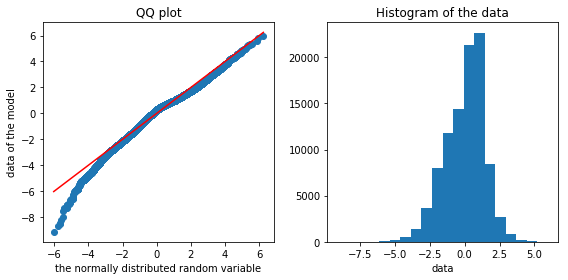

Jarque-Bera test statistics is 4613.310875507135 and p value is 0.0
Normality test statistics is 3935.7465185762912 and p value is 0.0


In [46]:
#7. ERRORS ARE NOT NORMALLY DISTRIBUTED. 

check_normality(errors)

We've found these concerns:  

* Error terms are highly correlated with each other. 
* The errors are not normally distributed. 

Next, I'll include the interaction of humidity and windspeed in the model.
  

In [48]:
#add the interaction of humidity and windspeed to the features dataframe
features["wind_humidity"] = weather_df.windspeed * weather_df.humidity

In [49]:
# create the model...
# Y is the target variable
Y = apparent_discrepancy
# X is the feature set which includes
# is_male and is_smoker variables
X = features

# We need to manually add a constant
# in statsmodels' sm
X = sm.add_constant(X)

lrm = sm.OLS(Y, X)

results = sm.OLS(Y, X).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.341
Model:                            OLS   Adj. R-squared:                  0.341
Method:                 Least Squares   F-statistic:                 1.666e+04
Date:                Wed, 29 May 2019   Prob (F-statistic):               0.00
Time:                        04:35:42   Log-Likelihood:            -1.6669e+05
No. Observations:               96453   AIC:                         3.334e+05
Df Residuals:                   96449   BIC:                         3.334e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0839      0.033      2.511      0.012       0.018       0.149
humidity          0.1775      0.043      4.133      0.000       0.093       0.262
windspeed         0.0905      0.002     36.797      0.000       0.086       0.095
wind_humidity    -0.2971      0.003    -88.470      0.000      -0.304      -0.291
==============================================================================
Omnibus:                     4849.937   Durbin-Watson:                   0.265
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             9295.404
Skew:                          -0.378   Prob(JB):                         0.00
Kurtosis:                       4.320   Cond. No.                         193.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Interpreting the coefficients: 

**Are the estimated coefficients statistically significant?**
The p value for both is 0.000 - very low indeed and indicates we can reject the null hypothessis that the coefficient for the underlying population is 0.  However, note that the errors are not normally distributed (see below).  Normally distributed errors are required for us to estimate the significance of coefficients.  

**Did the signs of the estimated coefficients for humidity and windspeed change?**
Yes, both are now positive.  As humidity rises apparent temperature less actual temperature decreases, i.e. they get closer together.  Likewise for wind speed.  That's intuitively appealing.  I would expect that humidity and windspeed would confuse our perception of temperature.  It's also intuitively appealing that wind and humidity co-occurring might mitigate each other (humidity making one feel hot and windspeed making one feel cold).

**Interpret the estimated coefficients. What are the relations between the target and the explanatory variables?**
If I put aside the concern about non-normal errors, and assume that the coefficients are significant, then on average...
* I would expect the discrepancy between apparent and actual temperature to rise by 0.2 degrees celsius times the unit change in humidity, in the absence of any wind.  
* I would expect the discrepance to rise by 0.1 degrees for each one unit change in windspeed, in the absence of any humidity.  
* If both wind and humidity are present, in addition to the individual relationships described above, I would expect the discrepancy to close by 0.3 degrees per windspeed-humidity unit. 

In [50]:
#1. linearity of models in their coefficients - the model chosen de facto satisfies this condition

In [51]:
#2. the error term should be zero on average - and it is very close.  No concerns here. 
#predictions = results.fittedvalues
predictions = results.predict(X)
errors = Y - predictions
print("Mean of the errors in the medical costs model is: {}".format(np.mean(errors)))

Mean of the errors in the medical costs model is: -3.2649325628946367e-16


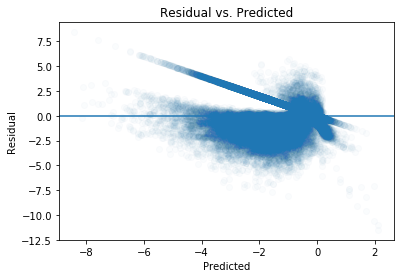

Bartlett test statistic value is 10245.3 and p value is 0
Levene test statistic value is 4959.63 and p value is 0


In [52]:
#3. homoscedasticity: the errors are consistently distributed  
plt.scatter(predictions, errors, alpha = .02)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

from scipy.stats import bartlett
from scipy.stats import levene

bart_stats = bartlett(predictions, errors)
lev_stats = levene(predictions, errors)

print("Bartlett test statistic value is {0:3g} and p value is {1:.3g}".format(bart_stats[0], bart_stats[1]))
print("Levene test statistic value is {0:3g} and p value is {1:.3g}".format(lev_stats[0], lev_stats[1]))

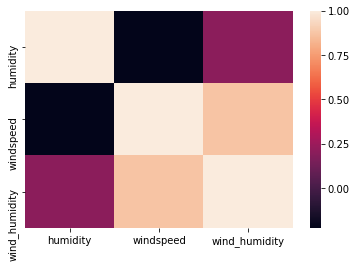

In [55]:
#4. WIND_SPEED AND WIND_HUMIDITY ARE HIGHLY CORRELATED
sns.heatmap(features.corr())
plt.show()

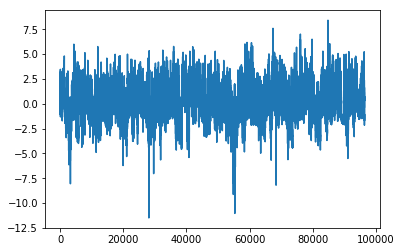

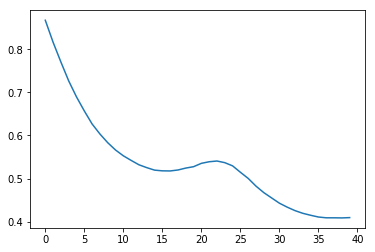

In [56]:
#5. ERROR TERMS ARE HIGHLY CORRELATED WITH EACH OTHER 
plt.plot(errors)
plt.show()

from statsmodels.tsa.stattools import acf

acf_data = acf(errors)

plt.plot(acf_data[1:])
plt.show()

In [57]:
#6. features shouldn't be correlated with the errors - and they aren't

f_err_corrs = [abs(features[feature].corr(errors)) for feature in features.columns]

high_corrs = [(x > 0.1) for x in f_err_corrs]

high_errs_df = pd.DataFrame([features.columns, f_err_corrs]).transpose()[high_corrs]
high_errs_df.columns = ["feature", "correlation with error >0.1"]
high_errs_df

,feature,correlation with error >0.1


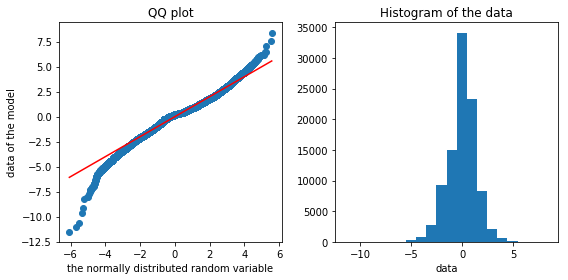

Jarque-Bera test statistics is 9295.40409608247 and p value is 0.0
Normality test statistics is 4849.937306202557 and p value is 0.0


In [58]:
#7. ERRORS ARE NOT NORMALLY DISTRIBUTED. 

check_normality(errors)

We've found these concerns:  

* Error terms are highly correlated with each other. 
* Windspeed and wind/humidity are highly correlated
* The errors are not normally distributed. 
